In [28]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [29]:
data=pl.read_csv("CarPrice_Assignment.csv").drop(["car_ID","CarName"])
data.head()

symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
1,"""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
2,"""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
2,"""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0


In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.drop("price").columns if data[col].dtype!= pl.String]
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

X = data.drop(['price']).to_pandas()
y = data['price'].to_pandas()

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [31]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['symboling', 'wheelbase',
                                                   'carlength', 'carwidth',
                                                   'carheight', 'curbweight',
                                                   'enginesize', 'boreratio',
                                                   'stroke', 'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fueltype', 'aspiration',
                                                   'doornumber', 'carbody',
                                                   'drivewheel',
                                                   'enginelocation',
                                                   'enginetype',
                                                   'cylindernumber',
                                                   'fuelsystem'])])),
                ('model', LinearRegression())])

In [32]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(pipe, X, y, cv=5, scoring='r2', return_train_score=True)

print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')
print(f'Mean Fit Time: {cv_results["fit_time"].mean()}')
print(f'Mean Score Time: {cv_results["score_time"].mean()}')

Test Scores: [ 0.60218047  0.62110719  0.08403797  0.57163394 -0.49442466]
Training Scores: [0.95974789 0.91997861 0.94901753 0.94416537 0.97125842]
Mean Test Score: 0.27690698170973543
Standard Deviation of Test Scores: 0.4343481444448835
Mean Fit Time: 0.011232328414916993
Mean Score Time: 0.004701375961303711


In [33]:
from sklearn.metrics import r2_score

def get_metrics(X,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    return r2,adjusted_r2

In [34]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)
pipe.fit(X_train,Y_train)
y_pred = pipe.predict(X_test)
get_metrics(X_test,Y_test,y_pred)

(0.8697971411928708, 0.6936403322185194)

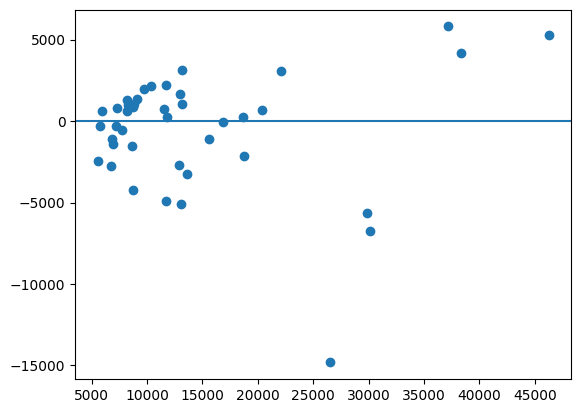

In [35]:
residuals=y_pred-Y_test
plt.scatter(y_pred,residuals)
plt.axhline(y=0)